# Import Packages

In [1]:
from zipfile import ZipFile
import xml.sax, xml.sax.handler
import numpy as np
import pickle
import xarray as xr
from shapely.geometry import Polygon, LineString
import utm
from pyproj import Proj
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.figsize'] = 18, 9
plt.rcParams['figure.facecolor'] = 'white'

# Define functions

In [2]:
class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""
        
def build_table(mapping):
    sep = ','
        
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
        
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [3]:
# parse the kmz
kmz = ZipFile('dunefields.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# loop through dune fields
for i in np.arange(0,np.shape(list(handler.mapping))[0]):
    coords = handler.mapping[list(handler.mapping)[i]]["coordinates"]
    my_list = coords.split(",")

    # restructure string of coordinates into a useful array
    verts = my_list[:-1]
    vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
    for j in np.arange(0,np.shape(verts)[0]):
        # deal with janky save structure of .kmz
        verts[j]=verts[j].replace('0 ','')
        verts[j]=verts[j].replace('0-','-')
        if j%2==0:
            vertsclean[int(j/2),0] = verts[j]
        else:
            vertsclean[int(j/2),1] = verts[j]
    # now have a coordinate array for the points of the boundary of each dune field
    vertups = np.asarray(vertsclean)

    # save each as a pickle
    with open('dunefields/df%d_verts.pkl'%i, 'wb') as f:
        pickle.dump(vertups, f)

# Load dune-field maps

In [4]:
Ndunefields = 45 #-1 for loops
dunefields = []
dunefields_avlat = np.empty(Ndunefields)
dunefields_avlon = np.empty(Ndunefields)
dunefields_area  = np.empty(Ndunefields)
for i in range(Ndunefields):
    with open('dunefields/df%d_verts.pkl'%i, 'rb') as f:
        vertups = pickle.load(f) # lon,lat

    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])
    dunefields_area[i] = Polygon(XY.T).area
    
    vertups[:,0] += 180
    dunefields.append(Polygon(vertups))
    dunefields_avlat[i] = dunefields[i].centroid.coords.xy[1][0]
    dunefields_avlon[i] = dunefields[i].centroid.coords.xy[0][0]

# Test maps and grab tiles for each dune field

In [5]:
field = xr.open_dataset('tslsi_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-18501231.nc')

In [6]:
lonM = np.asarray(field.lon)
lonD = np.diff(lonM)[0]/2
latM = np.asarray(field.lat)
latD = np.diff(latM)[0]/2

tiles = [[None for _ in range(len(latM))] for _ in range(len(lonM))]

for i in range(len(lonM)):
    for j in range(len(latM)):
        tiles[i][j] = Polygon([[lonM[i]+lonD,latM[j]+latD],
                               [lonM[i]-lonD,latM[j]+latD],
                               [lonM[i]-lonD,latM[j]-latD],
                               [lonM[i]+lonD,latM[j]-latD]])

tilefractionth = 0.0

Dunefield_dfinds = []
Dunefield_tileinds = []
Dunefield_tilelonlat = []
Dunefield_tilefractions = []
    
for k in range(Ndunefields):
    dunefield_dfinds = []
    dunefield_tileinds = []
    dunefield_tilelonlat = []
    dunefield_tilefractions = []
    for i in range(len(lonM)):
        for j in range(len(latM)):
            if tiles[i][j].overlaps(dunefields[k]):
                if tiles[i][j].intersection(dunefields[k]).area/tiles[i][j].area > tilefractionth:
                    dunefield_dfinds.append(k)
                    dunefield_tileinds.append([i,j])
                    dunefield_tilelonlat.append([lonM[i],latM[j]])
                    dunefield_tilefractions.append(tiles[i][j].intersection(dunefields[k]).area/tiles[i][j].area)
            elif tiles[i][j].within(dunefields[k]):
                dunefield_dfinds.append(k)
                dunefield_tileinds.append([i,j])
                dunefield_tilelonlat.append([lonM[i],latM[j]])
                dunefield_tilefractions.append(1)
    dunefield_tilefractions = np.asarray(dunefield_tilefractions)
    Dunefield_dfinds.append(dunefield_dfinds)
    Dunefield_tileinds.append(dunefield_tileinds)
    Dunefield_tilelonlat.append(dunefield_tilelonlat)
    Dunefield_tilefractions.append(dunefield_tilefractions)

(224.05078125, 237.19921875, 15.582152599529369, 28.73059009952937)

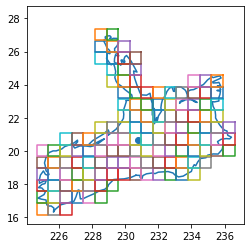

In [7]:
i = 11
plt.plot(dunefields[i].exterior.coords.xy[0],
            dunefields[i].exterior.coords.xy[1])
plt.scatter(dunefields_avlon[i],dunefields_avlat[i])
for k in range(len(Dunefield_tileinds[i])):
    plt.plot(tiles[Dunefield_tileinds[i][k][0]][Dunefield_tileinds[i][k][1]].exterior.coords.xy[0],
                tiles[Dunefield_tileinds[i][k][0]][Dunefield_tileinds[i][k][1]].exterior.coords.xy[1])
plt.axis('square')

In [8]:
Dunefield_dfinds = np.hstack(Dunefield_dfinds)
Dunefield_tileinds = np.vstack(Dunefield_tileinds)
Dunefield_tilelonlat = np.vstack(Dunefield_tilelonlat)
Dunefield_tilefractions = np.hstack(Dunefield_tilefractions)

with open('ec-earth3-firstdim-info.pkl', 'wb') as f:
    pickle.dump((Dunefield_dfinds,Dunefield_tileinds,Dunefield_tilelonlat,Dunefield_tilefractions),f)